#Assignment04. Origin-Destination Analysis with NetworkX

##Install and Import Packages

In [52]:
# Install packages

!pip install fiona
!pip install geopandas
!pip install folium
!pip install sodapy -q
!pip install adjustText
!pip install plotly --upgrade
!pip install contextily
!pip install mapclassify
!pip install chart-studio
!sudo apt install libspatialindex-dev
!pip install rtree
!pip install pygeos

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [53]:
!pip install decorator
!pip install pandapower

In [54]:
# Import packages
# To ignore unimporant system warnings
import warnings
warnings.filterwarnings("ignore")

# We will use Pandas, Numpy, and Matplotlib which is a package for visualization with Python
import pandas as pd
import numpy as np

# Load a required package 
# This is a library for accessing and parsing data through URLs
from urllib.parse import urlencode
import urllib.request, json 
from bs4 import BeautifulSoup # for web scraping
import fiona
import plotly.express as px
import geopandas as gpd
import adjustText as aT
import seaborn as sns # visualization styling package
import plotly.graph_objects as go
import urllib, json
import chart_studio.plotly as py
import chart_studio.tools as tls
import os
import plotly
from sodapy import Socrata
from IPython.display import Image, display
from shapely.geometry import shape
from shapely.geometry import Point 
from shapely.geometry import Polygon
import time
from shapely.geometry import shape
import contextily as ctx
from google.colab import files
from sklearn.preprocessing import MinMaxScaler

import networkx as nx #library supporting networks

%matplotlib inline 
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt
import seaborn as sns # visualization styling package
import folium
from folium.plugins import HeatMap

#Chart Studio API
import chart_studio
username='bkirthi'
api_key='PHHYaOZKZDA7BF3nUUtO'
chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

In [55]:
# import more packages
import plotly.io as pio
pio.renderers.default = "colab"
access_token = 'pk.eyJ1IjoiYmtpcnRoaSIsImEiOiJja3VpdzFiMnoycnYyMzBtYXM1aW1uemd0In0.knHw7eYrN8DvrrBHZugW8Q'
px.set_mapbox_access_token(access_token) # for interactive plotly viz

import plotly.graph_objects as go
import chart_studio.plotly as py
import chart_studio.tools as tls

##Import Citibike Rideshare Data
Downloadable from https://www.citibikenyc.com/system-data. Click “Downloadable files of Citi Bike trip data” or “Download Citi Bike trip history data”.

Here, download the data for August 2021.


In [56]:
# clone github
!git clone https://github.com/kirthi-b/CitiBike-NetworkX

fatal: destination path 'CitiBike-NetworkX' already exists and is not an empty directory.


In [57]:
aug = pd.read_csv("/content/CitiBike-NetworkX/Data/202108.csv")

In [58]:
aug.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5CABAE380FF3C7E0,classic_bike,2021-08-06 07:02:02,2021-08-06 07:28:56,Dey St,JC065,Stevens - River Ter & 6 St,HB602,40.737711,-74.066921,40.743133,-74.026989,casual
1,0C820F4E9256B5BB,classic_bike,2021-08-15 19:48:51,2021-08-15 20:04:45,Grand St & 2 St,HB405,Jersey & 3rd,JC074,40.739130,-74.036180,40.723332,-74.045953,member
2,F33B1B767F55A2BC,classic_bike,2021-08-26 17:14:58,2021-08-26 17:20:13,Grand St & 2 St,HB405,7 St & Monroe St,HB304,40.739130,-74.036180,40.746413,-74.037977,casual
3,EF7A1541C2302EEF,classic_bike,2021-08-12 12:58:22,2021-08-12 13:04:07,Dey St,JC065,Sip Ave,JC056,40.737711,-74.066921,40.730897,-74.063913,member
4,74DEC24E4C66BA01,classic_bike,2021-08-04 20:59:45,2021-08-04 21:10:39,Glenwood Ave,JC094,Pershing Field,JC024,40.727551,-74.071061,40.742677,-74.051789,member


In [59]:
print(aug.shape)

(93800, 13)


In [60]:
aug = aug[['ride_id','started_at','ended_at','start_station_name','end_station_name','start_lat','start_lng','end_lat','end_lng']]

In [86]:
aug_sub = aug_rev = aug[['start_station_name','start_lat','start_lng']]
aug_sub.shape[0]

93800

In [87]:
aug_rev = aug[['end_station_name','end_lat','end_lng']]
aug_rev = aug_rev.rename(columns={"end_station_name":"start_station_name","end_lat":"start_lat","end_lng":"start_lng"})
aug_rev.shape[0]

93800

In [62]:
#get count of rides per route
aug_count = aug.groupby(['start_station_name','end_station_name']).size().to_frame('count').reset_index()
aug_df = pd.DataFrame(aug_count)
aug_count.head()

,start_station_name,end_station_name,count
0,11 St & Washington St,11 St & Washington St,318
1,11 St & Washington St,12 St & Sinatra Dr N,31
2,11 St & Washington St,14 St Ferry - 14 St & Shipyard Ln,59
3,11 St & Washington St,4 St & Grand St,59
4,11 St & Washington St,6 St & Grand St,32


In [98]:
#get list of all routes
tot = pd.concat([aug_sub,aug_rev])
tot_count = tot.groupby(['start_station_name']).size().to_frame('count').reset_index()
tot_df = pd.DataFrame(tot_count)
tot_df.head()

,start_station_name,count
0,10 Ave & W 14 St,1
1,11 Ave & W 27 St,1
2,11 Ave & W 59 St,2
3,11 St & Washington St,4315
4,12 Ave & W 40 St,5


In [100]:
tot.shape[0]

187600

In [103]:
tot = tot.drop_duplicates()
tot.shape[0]

197

In [136]:
tot = pd.merge(tot, tot_df, on="start_station_name")

In [137]:
tot.head()

,start_station_name,start_lat,start_lng,count
0,Dey St,40.737711,-74.066921,493
1,Grand St & 2 St,40.739130,-74.036180,2909
2,Glenwood Ave,40.727551,-74.071061,764
3,Glenwood Ave,40.727551,-74.071061,764
4,Newport PATH,40.727224,-74.033759,5063


##Create a Network with CitiBike Station Names as Nodes

In [65]:
#create a dictionary of station locations
stations={}
for c in range(len(tot)):
    stations[tot['start_station_name'][c]]=(tot['start_lng'][c],tot['start_lat'][c])

In [66]:
stations

{'10 Ave & W 14 St': (-74.00831600000001, 40.741982),
 '11 Ave & W 27 St': (-74.00522600000001, 40.751396),
 '11 Ave & W 59 St': (-73.99046033620834, 40.771496710544405),
 '11 St & Washington St': (-74.02715027332306, 40.74998490907139),
 '12 Ave & W 40 St': (-74.00277668, 40.76087502),
 '12 St & Sinatra Dr N': (-74.0240201354027, 40.750604142368964),
 '14 St Ferry - 14 St & Shipyard Ln': (-74.02435272932054, 40.75296063046496),
 '4 St & Grand St': (-74.03511106967927, 40.7422579775645),
 '5 Corners Library': (-74.05950307846071, 40.73496102000952),
 '52 St & 1 Ave': (-74.020105, 40.649291999999996),
 '6 Ave & W 33 St': (-73.98848395, 40.74901271),
 '6 St & Grand St': (-74.03450086712837, 40.744397833095604),
 '7 St & Monroe St': (-74.03797701001167, 40.74641264837719),
 '8 Ave & W 33 St': (-73.993934, 40.751551),
 '8 St & Washington St': (-74.02819901704787, 40.74598388291562),
 '9 St HBLR - Jackson St & 8 St': (-74.0384115278721, 40.74790720968899),
 'Adams St & 11 St': (-74.03354063

In [67]:
#create a network with station names as nodes for august
aug_rides=nx.DiGraph()
aug_rides.add_nodes_from(aug['start_station_name'])

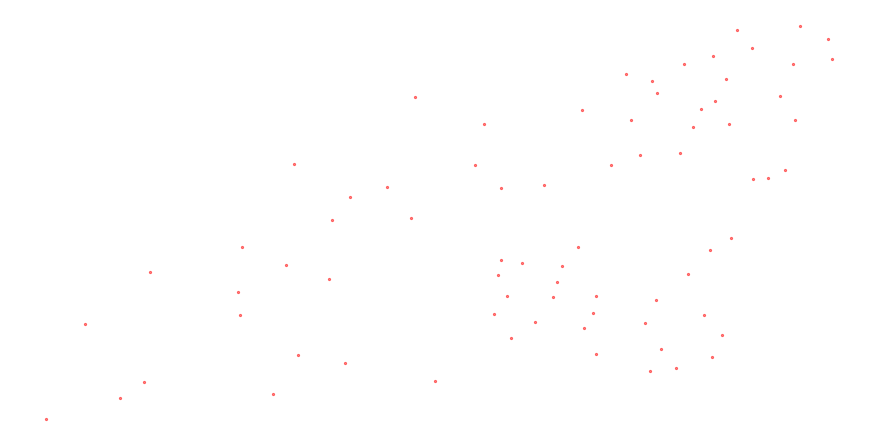

In [68]:
#visualize all the world airport cities
plt.figure(figsize = (12,6))
nx.draw(aug_rides, pos=stations, with_labels=False, arrows=False, node_size=5,
       node_color='red', alpha=0.5)

##Add Edges

In [69]:
# create list of edges as tuples
# create list of 0 first

#for august
aug_EN=len(aug_df.index)
edgelist=[0]*aug_EN
print (edgelist[:5])

[0, 0, 0, 0, 0]


In [70]:
# create list of edges as tuples for august
for j in range(0,aug_EN):
    edgelist[j]=(aug_df['start_station_name'][j],aug_df['end_station_name'][j], aug_df['count'][j])
edgelist

[('11 St & Washington St', '11 St & Washington St', 318),
 ('11 St & Washington St', '12 St & Sinatra Dr N', 31),
 ('11 St & Washington St', '14 St Ferry - 14 St & Shipyard Ln', 59),
 ('11 St & Washington St', '4 St & Grand St', 59),
 ('11 St & Washington St', '6 St & Grand St', 32),
 ('11 St & Washington St', '7 St & Monroe St', 45),
 ('11 St & Washington St', '8 St & Washington St', 78),
 ('11 St & Washington St', '9 St HBLR - Jackson St & 8 St', 49),
 ('11 St & Washington St', 'Adams St & 11 St', 27),
 ('11 St & Washington St', 'Baldwin at Montgomery', 3),
 ('11 St & Washington St', 'Bloomfield St & 15 St', 37),
 ('11 St & Washington St', 'Brunswick St', 3),
 ('11 St & Washington St', 'Christ Hospital', 3),
 ('11 St & Washington St', 'Church Sq Park - 5 St & Park Ave', 107),
 ('11 St & Washington St', 'Clinton St & 7 St', 46),
 ('11 St & Washington St', 'Columbus Dr at Exchange Pl', 3),
 ('11 St & Washington St', 'Columbus Drive', 7),
 ('11 St & Washington St', 'Columbus Park - Clin

In [71]:
# add edges to the network
aug_rides.add_weighted_edges_from(edgelist)

In [72]:
print (aug_rides.in_degree(weight='weight')['Newport PATH'])
print (aug_rides.out_degree(weight='weight')['Newport PATH'])

2533
2517


###Incoming and outgoing degree

In [73]:
# Convert pandas dataframe and join two information - august
in_degree = pd.DataFrame.from_dict(dict(aug_rides.in_degree()), orient='index').reset_index()
in_degree.columns = ['start_station_name', 'in_degree']
out_degree = pd.DataFrame.from_dict(dict(aug_rides.out_degree()), orient='index').reset_index()
out_degree.columns = ['start_station_name', 'out_degree']

in_degree.head()

,start_station_name,in_degree
0,Dey St,37
1,Grand St & 2 St,62
2,Glenwood Ave,47
3,Newport PATH,73
4,Columbus Dr at Exchange Pl,72


In [74]:
in_out_degree = pd.merge(in_degree, out_degree, how='outer', on='start_station_name')
in_out_degree.sort_values(by='in_degree', ascending=False).head(10)

,start_station_name,in_degree,out_degree
3,Newport PATH,73,74
28,Warren St,73,73
40,Washington St,72,76
4,Columbus Dr at Exchange Pl,72,73
13,Grove St PATH,72,75
23,Hamilton Park,72,71
55,Manila & 1st,71,70
68,Newark Ave,71,69
35,Brunswick St,71,69
65,Newport Pkwy,71,75


In [75]:
print(aug_rides.in_degree())
print(aug_rides.out_degree())

[('Dey St', 37), ('Grand St & 2 St', 62), ('Glenwood Ave', 47), ('Newport PATH', 73), ('Columbus Dr at Exchange Pl', 72), ('Pershing Field', 66), ('South Waterfront Walkway - Sinatra Dr & 1 St', 69), ('McGinley Square', 56), ('6 St & Grand St', 46), ('Jersey & 3rd', 61), ('7 St & Monroe St', 53), ('Morris Canal', 46), ('Heights Elevator', 63), ('Grove St PATH', 72), ('Clinton St & 7 St', 54), ('Willow Ave & 12 St', 50), ('Lafayette Park', 51), ('JC Medical Center', 58), ('Astor Place', 51), ('Liberty Light Rail', 55), ('14 St Ferry - 14 St & Shipyard Ln', 58), ('Grand St', 62), ('Essex Light Rail', 54), ('Hamilton Park', 72), ('Columbus Drive', 68), ('Journal Square', 53), ('Bergen Ave', 48), ('Madison St & 10 St', 39), ('Warren St', 73), ('Hilltop', 62), ('Harborside', 66), ('Jersey & 6th St', 55), ('Paulus Hook', 61), ('Jackson Square', 43), ('Montgomery St', 60), ('Brunswick St', 71), ('Riverview Park', 63), ('Church Sq Park - 5 St & Park Ave', 63), ('Monmouth and 6th', 64), ('11 St

###Visualize the Citibike Routes Network

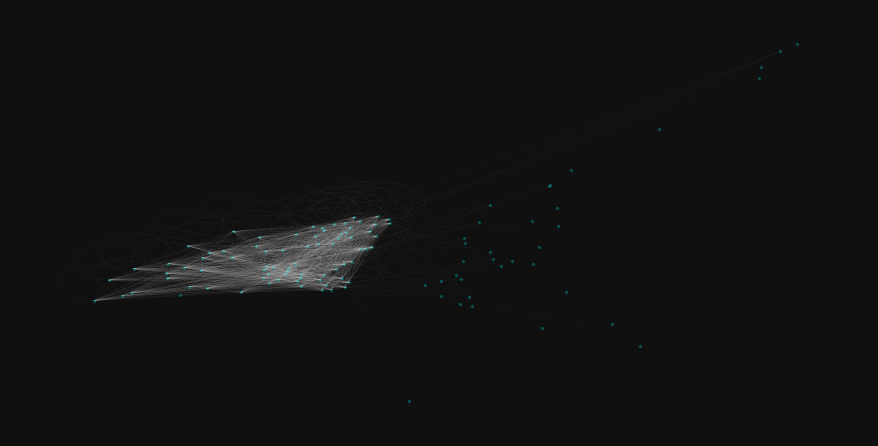

In [76]:
#visualize the network
fig = plt.figure(figsize = (12,6))
nx.draw(aug_rides, pos=stations, with_labels=False, arrows=False, node_size=5,
       node_color='cyan', alpha=0.2, style='dotted', edge_color='white', width=0.2)
fig.set_facecolor("#101010")

In [141]:
fig = px.scatter_mapbox(tot,
                    lat='start_lat',
                    lon='start_lng',
                        color_discrete_sequence=px.colors.qualitative.Plotly,
                       mapbox_style='dark',
                        size = 'count',
                        hover_data = {'start_station_name': True})

fig.update_layout(autosize=False,
                 width=1000,
                 height=800)

fig.update_layout(mapbox_zoom=10, 
                  mapbox_center = {"lat": 40.776789, "lon": -73.970212})
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

##Check other centrality scores of stations
* Degree centrality
* Eigenvector centrality

In [122]:
#output top ten centrality scores, given the dictionary d
def topdict(d,tn):
#     ind=sorted(d, key=dict(d).get, reverse=True)
    ind = sorted(dict(c1), key=dict(c1).__getitem__, reverse=True)
    for i in range(0,tn):
        print('{0}|{1}:{2}'.format(i+1,ind[i],d[ind[i]]))

Now compute five centrality metrics - degree, eigenvector, betweenness, closeness and pagerank - and output top 10 stations in terms according to those metrics

In [123]:
# Degree centrality
c1= nx.degree(aug_rides)
topdict(c1,10)

1|Washington St:148
2|Newport PATH:147
3|Grove St PATH:147
4|South Waterfront Walkway - Sinatra Dr & 1 St:146
5|Warren St:146
6|Newport Pkwy:146
7|Columbus Dr at Exchange Pl:145
8|Hamilton Park:143
9|Hoboken Terminal - Hudson St & Hudson Pl:142
10|Manila & 1st:141


In [124]:
# Eigenvector centrality
c2= nx.eigenvector_centrality(aug_rides)
topdict(c2,10)

1|Washington St:0.1397519152499158
2|Newport PATH:0.14179565257778157
3|Grove St PATH:0.13874000791584348
4|South Waterfront Walkway - Sinatra Dr & 1 St:0.1346402138986615
5|Warren St:0.1417354321565642
6|Newport Pkwy:0.13864036955630302
7|Columbus Dr at Exchange Pl:0.14038215821111297
8|Hamilton Park:0.14020704281148944
9|Hoboken Terminal - Hudson St & Hudson Pl:0.1368726734513501
10|Manila & 1st:0.1372638214573964


In [125]:
#Betweenness centrality
c3 = nx.betweenness_centrality(aug_rides)
topdict(c3,10)

1|Washington St:0.01653080021784583
2|Newport PATH:0.004259323855414464
3|Grove St PATH:0.008049864299299103
4|South Waterfront Walkway - Sinatra Dr & 1 St:0.019704935402343672
5|Warren St:0.004080906374229296
6|Newport Pkwy:0.019738009746168628
7|Columbus Dr at Exchange Pl:0.0182476051841674
8|Hamilton Park:0.0036374236037274503
9|Hoboken Terminal - Hudson St & Hudson Pl:0.00978003537279552
10|Manila & 1st:0.0037177162485484247


In [126]:
#Closeness centrality
c4 = nx.closeness_centrality(aug_rides)
topdict(c4,10)

1|Washington St:0.647295742232451
2|Newport PATH:0.6555944055944055
3|Grove St PATH:0.647295742232451
4|South Waterfront Walkway - Sinatra Dr & 1 St:0.6236141906873613
5|Warren St:0.6555944055944055
6|Newport Pkwy:0.6392045454545454
7|Columbus Dr at Exchange Pl:0.647295742232451
8|Hamilton Park:0.647295742232451
9|Hoboken Terminal - Hudson St & Hudson Pl:0.6313131313131313
10|Manila & 1st:0.6392045454545454


##Visualize the network with the node size proportional to the degree centrality (or any other centrality)

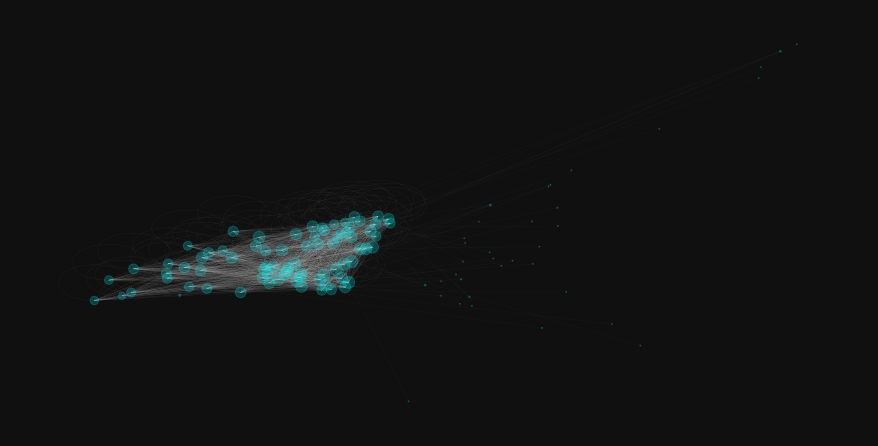

In [127]:
node_size_original = list(dict(c1).values()) # based on degree centrality

#visualize the network
fig = plt.figure(figsize = (12,6))
nx.draw(aug_rides, pos=stations, with_labels=False,arrows=False, 
        node_size=node_size_original, 
       node_color='cyan', alpha=0.2, style='dotted', edge_color='white', width=0.2)
fig.set_facecolor("#101010")